In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

In [2]:

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
from google.colab import files
files.upload()


Saving Cost_of_Living_Index_2022.csv to Cost_of_Living_Index_2022.csv


{'Cost_of_Living_Index_2022.csv': b'Rank,Country,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index\r\n1,Afghanistan,20.37,2.72,12.09,14.92,12.41,23.04\r\n2,Albania,35.5,8.47,22.83,29.32,25.82,30.19\r\n3,Algeria,26.87,4.59,16.43,28.82,14.48,24.63\r\n4,Argentina,34.69,7.71,22.04,28.17,33.32,30.72\r\n5,Armenia,33.89,11.61,23.45,27.59,30.55,28.86\r\n6,Australia,77.75,36.84,58.57,77.44,72.95,104.63\r\n7,Austria,71.04,27.13,50.46,65.88,66.03,77.25\r\n8,Azerbaijan,29.73,7.86,19.48,26.57,26.73,27.26\r\n9,Bahamas,84,35.34,61.19,70.59,89.09,45.07\r\n10,Bahrain,54.77,29.22,42.79,44.59,48.94,61.41\r\n11,Bangladesh,33.13,4.42,19.67,30.41,21.7,25.3\r\n12,Barbados,92.37,21.99,59.38,87.81,78.18,32.08\r\n13,Belarus,30.89,9.81,21.01,27.24,31.64,31.78\r\n14,Belgium,72.61,25.79,50.67,63.32,78.63,79.72\r\n15,Belize,51.3,11.64,32.71,48.76,36.6,45.73\r\n16,Bermuda,146.04,98.58,123.8,148.66,159.17,81.07\r\n17,Bolivia,34.77,10.18,

In [3]:
coli = spark.read.csv('Cost_of_Living_Index_2022.csv',inferSchema=True, header=True)

In [25]:
coli.columns

['Cost of Living Index',
 'Rent Index',
 'Cost of Living Plus Rent Index',
 'Groceries Index',
 'Restaurant Price Index',
 'Local Purchasing Power Index']

In [4]:
coli.show(5)

+----+-----------+--------------------+----------+------------------------------+---------------+----------------------+----------------------------+
|Rank|    Country|Cost of Living Index|Rent Index|Cost of Living Plus Rent Index|Groceries Index|Restaurant Price Index|Local Purchasing Power Index|
+----+-----------+--------------------+----------+------------------------------+---------------+----------------------+----------------------------+
|   1|Afghanistan|               20.37|      2.72|                         12.09|          14.92|                 12.41|                       23.04|
|   2|    Albania|                35.5|      8.47|                         22.83|          29.32|                 25.82|                       30.19|
|   3|    Algeria|               26.87|      4.59|                         16.43|          28.82|                 14.48|                       24.63|
|   4|  Argentina|               34.69|      7.71|                         22.04|          28.17|   

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler,StandardScaler,PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
coli.summary().show()


+-------+-----------------+-----------+--------------------+------------------+------------------------------+------------------+----------------------+----------------------------+
|summary|             Rank|    Country|Cost of Living Index|        Rent Index|Cost of Living Plus Rent Index|   Groceries Index|Restaurant Price Index|Local Purchasing Power Index|
+-------+-----------------+-----------+--------------------+------------------+------------------------------+------------------+----------------------+----------------------------+
|  count|              139|        139|                 139|               139|                           139|               139|                   139|                         139|
|   mean|             70.0|       null|   50.18863309352518| 19.29151079136691|             35.70532374100718|46.637841726618696|     43.44489208633094|           46.42625899280576|
| stddev|40.26992260567019|       null|   20.86022212150693|15.317725590510719|           

Text(0.5, 1.0, 'The Histogram of Cost of Living Index')

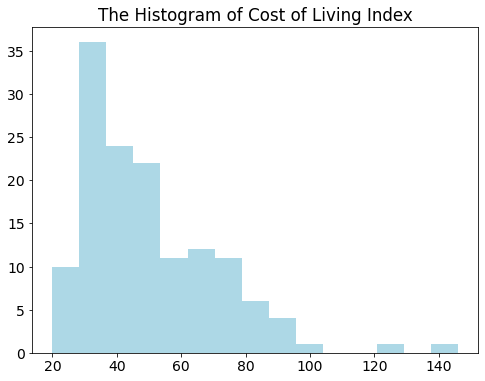

In [35]:
import matplotlib.pyplot as plt
cost = coli.select('Cost of Living Index')
cost = coli.select("Cost of Living Index").rdd.flatMap(lambda x:x).collect()
n,bins, patches = plt.hist(cost, 15,facecolor = "lightblue")
plt.title("The Histogram of Cost of Living Index")

In [24]:

#Correaltion matrix 
#To find the variables with high correaltion with target variables
coli = coli.drop('Country')
for column in coli.columns:
    print('The Correaltion value of {} with Cost of Living Index is {}'.format(
          column, coli.stat.corr('Cost of Living Index',column)))

The Correaltion value of Cost of Living Index with Cost of Living Index is 1.0
The Correaltion value of Rent Index with Cost of Living Index is 0.8380788185254173
The Correaltion value of Cost of Living Plus Rent Index with Cost of Living Index is 0.974751841713541
The Correaltion value of Groceries Index with Cost of Living Index is 0.9654354432739343
The Correaltion value of Restaurant Price Index with Cost of Living Index is 0.9345052509988597
The Correaltion value of Local Purchasing Power Index with Cost of Living Index is 0.6872435031469392


In [26]:
features= [
 'Rent Index',
 'Cost of Living Plus Rent Index',
 'Groceries Index',
 'Restaurant Price Index',
 'Local Purchasing Power Index']
assembler = VectorAssembler(inputCols=features,outputCol='features')

In [27]:
coli_feat = assembler.transform(coli).select('features')


In [28]:
## Standardise the dataset
std_scaler= StandardScaler(inputCol='features',outputCol='scaledFeature',withMean=True,withStd=True).fit(coli_feat)
df_scaled = std_scaler.transform(coli_feat)
df_scaled.show(5)

+--------------------+--------------------+
|            features|       scaledFeature|
+--------------------+--------------------+
|[2.72,12.09,14.92...|[-1.0818519168167...|
|[8.47,22.83,29.32...|[-0.7064698167768...|
|[4.59,16.43,28.82...|[-0.9597711294994...|
|[7.71,22.04,28.17...|[-0.7560855378256...|
|[11.61,23.45,27.5...|[-0.5014785482333...|
+--------------------+--------------------+
only showing top 5 rows



In [29]:
#Train model for PCA 
n_components=2
pca = PCA(k=n_components,inputCol='scaledFeature',outputCol='pcafeatures').fit(df_scaled)

df_pca=pca.transform(df_scaled)
print('Explained Variance Ratio',pca.explainedVariance.toArray())
df_pca.show(5)
     

Explained Variance Ratio [0.83563975 0.09073799]
+--------------------+--------------------+--------------------+
|            features|       scaledFeature|         pcafeatures|
+--------------------+--------------------+--------------------+
|[2.72,12.09,14.92...|[-1.0818519168167...|[2.73014990661113...|
|[8.47,22.83,29.32...|[-0.7064698167768...|[1.60430635382840...|
|[4.59,16.43,28.82...|[-0.9597711294994...|[2.19359044632723...|
|[7.71,22.04,28.17...|[-0.7560855378256...|[1.52765461099296...|
|[11.61,23.45,27.5...|[-0.5014785482333...|[1.46452047677317...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [30]:
#Collect distributed data in numpy
pca = df_pca.rdd.map(lambda row:row.pcafeatures).collect()
pca= np.array(pca)

In [31]:
pca

array([[ 2.73014991e+00, -2.14729094e-01],
       [ 1.60430635e+00, -2.67229081e-02],
       [ 2.19359045e+00, -5.23074160e-03],
       [ 1.52765461e+00, -5.88955700e-02],
       [ 1.46452048e+00,  6.08391842e-02],
       [-3.18815047e+00, -9.75933399e-01],
       [-1.91019620e+00, -4.49767811e-01],
       [ 1.79925067e+00, -8.02169404e-03],
       [-2.51301886e+00,  1.00643723e+00],
       [-7.57635778e-01, -2.95913938e-01],
       [ 1.93237656e+00,  4.75921077e-02],
       [-2.05795022e+00,  1.42930278e+00],
       [ 1.53031523e+00, -9.34499700e-02],
       [-2.08844144e+00, -5.48718201e-01],
       [ 3.97039785e-01, -1.11387318e-01],
       [-9.59084430e+00,  2.62031643e+00],
       [ 1.43274786e+00, -1.72911403e-01],
       [ 1.43527874e+00, -5.04320725e-01],
       [ 5.64973444e-01, -9.41155715e-01],
       [ 1.71500001e+00,  1.81524709e-02],
       [ 1.08753710e+00, -4.52216678e-01],
       [ 9.34034685e-01,  1.03918566e+00],
       [ 1.57401862e+00,  6.15010684e-01],
       [-2.

In [32]:
#Convert into pandas dataframe
coli_pca=pd.DataFrame(pca, columns=['PC1','PC2'])
coli_pca.head()

,PC1,PC2
0,2.730150,-0.214729
1,1.604306,-0.026723
2,2.193590,-0.005231
3,1.527655,-0.058896
4,1.464520,0.060839


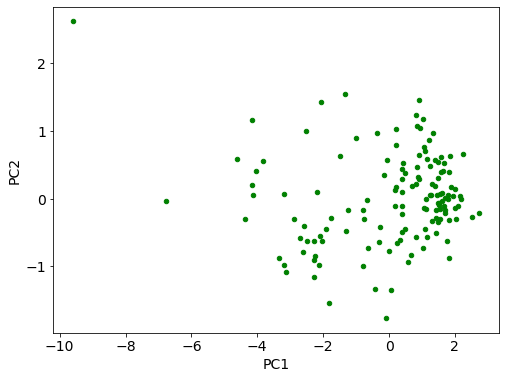

In [33]:
## Plot 2 principle components
plt.rcParams['figure.figsize']=8,6
plt.rcParams['font.size']=14
ax1=coli_pca.plot.scatter(x='PC1',y='PC2',c='green')
     

In [36]:
output=assembler.transform(coli)
f_data=output.select('features','Cost of Living Index')
f_data.show(5)
     

+--------------------+--------------------+
|            features|Cost of Living Index|
+--------------------+--------------------+
|[2.72,12.09,14.92...|               20.37|
|[8.47,22.83,29.32...|                35.5|
|[4.59,16.43,28.82...|               26.87|
|[7.71,22.04,28.17...|               34.69|
|[11.61,23.45,27.5...|               33.89|
+--------------------+--------------------+
only showing top 5 rows



In [37]:
#Linear Regression
#Split data into training and testing data
train_data,test_data= f_data.randomSplit([0.70,0.3]) 

In [38]:
##Fit model for linear regression
regressor=LinearRegression(featuresCol='features',labelCol='Cost of Living Index')
regressor=regressor.fit(train_data)


In [39]:
#Model coefficient and intercept
coeff=regressor.coefficients
intr=regressor.intercept

In [40]:
print("Model's coefficient: ",coeff)

Model's coefficient:  [-0.8825881193692902,1.8828434074875133,-0.0001212109891168446,-0.00015170796694687907,2.651641901212375e-05]


In [42]:
#Evaluate the model and test data 
pred= regressor.evaluate(test_data)
pred.predictions.show(5)

+--------------------+--------------------+------------------+
|            features|Cost of Living Index|        prediction|
+--------------------+--------------------+------------------+
|[5.17,17.7,29.34,...|               28.75|28.754778488215354|
|[6.91,24.22,40.41...|               39.48| 39.49357117379713|
|[7.71,22.04,28.17...|               34.69|34.683732260828585|
|[8.18,18.03,23.47...|               26.72|26.721339593226613|
|[8.27,21.54,28.16...|               33.24| 33.24921212059828|
+--------------------+--------------------+------------------+
only showing top 5 rows



In [45]:
from pyspark.ml.evaluation import RegressionEvaluator
eval=RegressionEvaluator(labelCol='Cost of Living Index',predictionCol='prediction',metricName='rmse')

rmse=eval.evaluate(pred.predictions)
print(f"RMSE value of this model : {rmse}")

mse=eval.evaluate(pred.predictions,{eval.metricName:"mse"})
print(f"MSE VALUE : {mse}")

mae=eval.evaluate(pred.predictions,{eval.metricName:"mae"})
print(f"MAE VALUE : {mae}")

r2=eval.evaluate(pred.predictions,{eval.metricName:"r2"})
print(f"The accuracy score (r2 score): {r2}")
     

RMSE value of this model : 0.006343575122465187
MSE VALUE : 4.024094533435921e-05
MAE VALUE : 0.005537477656233432
The accuracy score (r2 score): 0.9999998728844466
